<a href="https://colab.research.google.com/github/nandasimatupang/skripsoy/blob/main/codingan/klasifikasi_aspek_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Load data
df = pd.read_csv("pantai_terlabeli.csv")
df= df[['ulasan','aspect']]
df["aspect"] = df["aspect"].map({'Fasilitas':0,'Akses':1,'Kebersihan':2,'Pemandangan':3,'Harga':4})

<Axes: ylabel='count'>

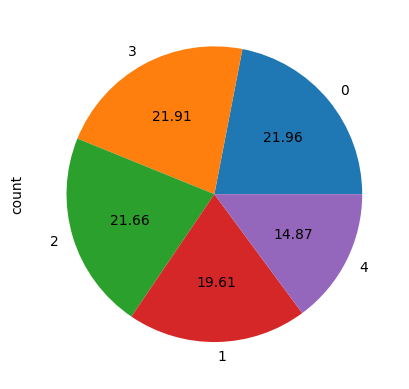

In [ ]:
df['aspect'].value_counts().plot.pie(autopct='%.2f')

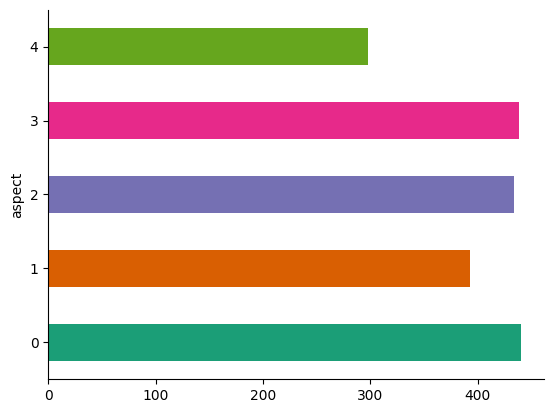

In [ ]:
df.groupby('aspect').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)
df_train.shape, df_test.shape, df_val.shape
print('Training data shape:', df_train.shape)
print('Validation data shape:', df_val.shape)
print('Test data shape:', df_test.shape)

Training data shape: (1603, 2)
Validation data shape: (200, 2)
Test data shape: (201, 2)


In [ ]:
df_train.to_csv('data_training.csv', index = False)
data = pd.read_csv('data_training.csv')
data.head()

,ulasan,aspect
0,Kalau kamu cari pantai buat mandi2 sepertinya ...,2
1,Nyaman.. bersih.. luas pula,2
2,Mines di akses masuk rusak batu2 ga ada perbai...,1
3,"Pantai ini sangat bagus, lingkungan sekitar se...",0
4,"Sampah di tepi pantai, perlu dibersihkan",2


In [ ]:
df_train.to_csv('data_training.csv', index = False)
data = pd.read_csv('data_training.csv')
data.head()

,ulasan,aspect
0,Kalau kamu cari pantai buat mandi2 sepertinya ...,2
1,Nyaman.. bersih.. luas pula,2
2,Mines di akses masuk rusak batu2 ga ada perbai...,1
3,"Pantai ini sangat bagus, lingkungan sekitar se...",0
4,"Sampah di tepi pantai, perlu dibersihkan",2


In [ ]:
#Modelling
!pip install transformers

In [ ]:
from transformers import BertTokenizer

# Load tokenizer dari pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

In [ ]:

# Added special tokens for all data as input formatting to the BERT model
def convert_example_to_feature(sentence):
  return bert_tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      padding='max_length',
      truncation='longest_first',
      max_length=42,
      return_attention_mask=True,
      return_token_type_ids=True)

In [ ]:
# Create a function to map input formatting results to match the BERT model
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

In [ ]:
import tensorflow as tf
# Create a function to iterate or encode each sentence in the entire data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for sentence, label in data.to_numpy():
    bert_input = convert_example_to_feature(sentence)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# Perform input formatting using the previous function on the data as a whole
train_encoded = encode(df_train).batch(32)
test_encoded = encode(df_test).batch(32)
val_encoded = encode(df_val).batch(32)

In [ ]:
from transformers import TFBertForSequenceClassification

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# import tensorflow as tf

# # Define the number of samples for each class
# class_counts = np.array([420, 390, 410, 410, 280])

# # Calculate the total number of samples
# total_samples = np.sum(class_counts)

# # Calculate class weights (inverse of the frequency)
# # class_weights = total_samples / (len(class_counts) * class_counts)
# print("Class weights:", class_weights)

# # Convert class weights to a tensor
# class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

Class weights: [0.90952381 0.97948718 0.93170732 0.93170732 1.36428571]


In [ ]:
# # Custom weighted categorical crossentropy loss function
# def weighted_categorical_crossentropy(y_true, y_pred):
#     # Flatten y_true to ensure it is 1D
#     y_true = tf.reshape(y_true, [-1])

#      # Convert the sparse labels to one-hot encoding
#     y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))

#     # Calculate the unweighted cross-entropy loss
#     unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true_one_hot, y_pred, from_logits=True)
#  # Apply the weights
#     weights = tf.reduce_sum(class_weights_tensor * y_true_one_hot, axis=-1)
#     weighted_loss = unweighted_loss * weights

#     return tf.reduce_mean(weighted_loss)

In [ ]:
# Compile model
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [ ]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=10,
                              batch_size=32, validation_data=val_encoded)

Epoch 1/10
51/51 [==============================] - 92s 558ms/step - loss: 0.6438 - accuracy: 0.7654 - val_loss: 0.4946 - val_accuracy: 0.8300
Epoch 2/10
51/51 [==============================] - 16s 324ms/step - loss: 0.3526 - accuracy: 0.8890 - val_loss: 0.5669 - val_accuracy: 0.8550
Epoch 3/10
51/51 [==============================] - 16s 307ms/step - loss: 0.2648 - accuracy: 0.9270 - val_loss: 0.6107 - val_accuracy: 0.8450
Epoch 4/10
51/51 [==============================] - 16s 321ms/step - loss: 0.1805 - accuracy: 0.9526 - val_loss: 0.5248 - val_accuracy: 0.8750
Epoch 5/10
51/51 [==============================] - 17s 325ms/step - loss: 0.1753 - accuracy: 0.9501 - val_loss: 0.7827 - val_accuracy: 0.7950
Epoch 6/10
51/51 [==============================] - 16s 311ms/step - loss: 0.1292 - accuracy: 0.9682 - val_loss: 0.5487 - val_accuracy: 0.8550
Epoch 7/10
51/51 [==============================] - 16s 322ms/step - loss: 0.1314 - accuracy: 0.9707 - val_loss: 0.6311 - val_accuracy: 0.8500

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Create a function for plotting training results
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

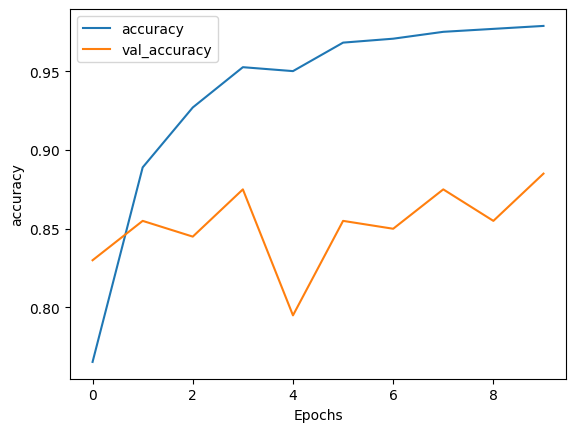

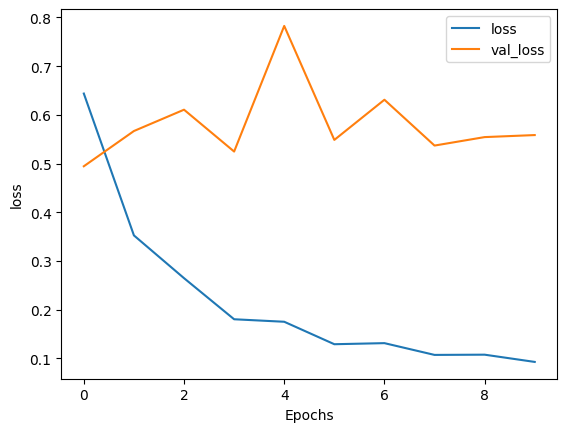

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
bert_model.save_weights('klasifikasi_aspek.h5')

In [ ]:
%%time
score = bert_model.evaluate(test_encoded)
print("Test Accuracy:", score[1])

7/7 [==============================] - 1s 93ms/step - loss: 0.3673 - accuracy: 0.9254
Test Accuracy: 0.9253731369972229
CPU times: user 347 ms, sys: 39.6 ms, total: 387 ms
Wall time: 1.29 s


In [ ]:
predicted_raw = bert_model.predict(test_encoded)

7/7 [==============================] - 12s 101ms/step


In [ ]:
import numpy as np
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(df_test['aspect'])
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy_score(y_true, y_pred)

0.8656716417910447

In [ ]:
confusion_matrix(y_true, y_pred)

array([[36,  1,  2,  4,  0],
       [ 4, 42,  1,  3,  0],
       [ 0,  1, 39,  0,  1],
       [ 3,  0,  0, 29,  0],
       [ 2,  2,  0,  3, 28]])

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        43
           1       0.91      0.84      0.87        50
           2       0.93      0.95      0.94        41
           3       0.74      0.91      0.82        32
           4       0.97      0.80      0.88        35

    accuracy                           0.87       201
   macro avg       0.87      0.87      0.86       201
weighted avg       0.87      0.87      0.87       201



In [ ]:
input_text = 'sangat indah parkir mahal'

# Encode input text
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')


# Make predictions
bert_predict = bert_model(input_text_tokenized)

# Softmax for probabilities (instead of just the class)
bert_output_probabilities = tf.nn.softmax(bert_predict[0], axis=-1)
# Softmax function to get classification results
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)

label_index = tf.argmax(bert_output_probabilities, axis=1)
label_index = label_index.numpy()[0]  # Extract the value from the numpy array
label_probability = bert_output_probabilities.numpy()[0][label_index]

print(input_text, ':', sentiment_labels[label_index],
      f"(Probability: {label_probability:.2f})")  # Format probability to 2 decimal places

sangat indah parkir mahal : Harga (Probability: 0.99)


In [ ]:
# Function to predict the aspect of a single review
def predict_aspect(review):
    input_text_tokenized = bert_tokenizer.encode(review,
                                                 truncation=True,
                                                 padding='max_length',
                                                 return_tensors='tf')
    bert_predict = bert_model(input_text_tokenized)
    bert_output_probabilities = tf.nn.softmax(bert_predict[0], axis=-1)
    label_index = tf.argmax(bert_output_probabilities, axis=1).numpy()[0]
    label_probability = bert_output_probabilities.numpy()[0][label_index]
    aspect_label = sentiment_labels[label_index]
    return aspect_label, label_probability

# Read the CSV file
input_csv = 'semua_data.csv'  # Replace with your input CSV file path
df = pd.read_csv(input_csv)

In [ ]:
df

,Unnamed: 0,user,ulasan
0,0,Didit lugmana,"Pantai bagus, banyak penginapan, orangnya rama..."
1,1,Candra Widarusanto,"Pantai nya sebetulnya bagus, cuma akses jalan ..."
2,2,Gaguk Amin,Keren
3,3,RICO PRASETIAWAN,Rame kalau wekend
4,4,NINDYA ADITA,Ikon utama yg menarik pengunjung adalah Purany...
...,...,...,...
12000,470,Wahyu Yani,"Pasirnya putih,ombaknya bersahabat wktu itu q ..."
12001,471,Laila 1,pas untuk santai
12002,472,anwar s,"Pantainya bersih, jalur menuju pantai baik."
12003,473,Dedy Dinata,Tempatnya bersih dan banyak lokasi selfie.


In [ ]:
# Make predictions for each review in the 'ulasan' column
df['aspek'] = df['ulasan'].apply(lambda x: predict_aspect(x)[0])

In [ ]:
df

,Unnamed: 0,user,ulasan,aspek
0,0,Didit lugmana,"Pantai bagus, banyak penginapan, orangnya rama...",Fasilitas
1,1,Candra Widarusanto,"Pantai nya sebetulnya bagus, cuma akses jalan ...",Akses
2,2,Gaguk Amin,Keren,Pemandangan
3,3,RICO PRASETIAWAN,Rame kalau wekend,Pemandangan
4,4,NINDYA ADITA,Ikon utama yg menarik pengunjung adalah Purany...,Fasilitas
...,...,...,...,...
12000,470,Wahyu Yani,"Pasirnya putih,ombaknya bersahabat wktu itu q ...",Pemandangan
12001,471,Laila 1,pas untuk santai,Pemandangan
12002,472,anwar s,"Pantainya bersih, jalur menuju pantai baik.",Akses
12003,473,Dedy Dinata,Tempatnya bersih dan banyak lokasi selfie.,Kebersihan


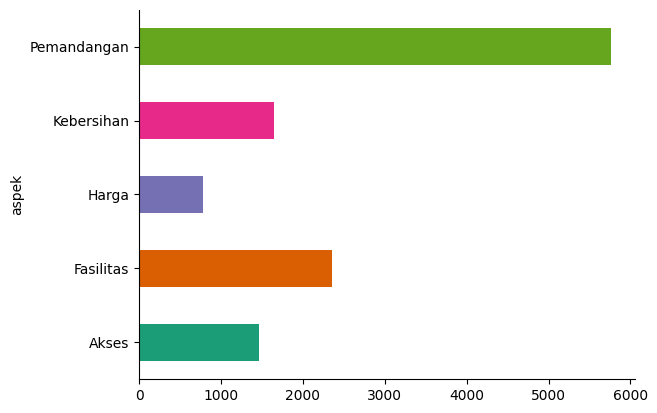

In [ ]:
# @title aspek

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('aspek').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.to_csv('semua_data_terlabeli.csv')